# Multi-dimensional interpolation example for O$_2$sclpy

See the O$_2$sclpy documentation at https://neutronstars.utk.edu/code/o2sclpy for more information.

In [1]:
import o2sclpy
import matplotlib.pyplot as plot
import ctypes
import numpy
import sys

plots=True
if 'pytest' in sys.modules:
    plots=False

Link the O$_2$scl library:

In [2]:
link=o2sclpy.linker()
link.link_o2scl()

Create the data set:

In [3]:
ug=o2sclpy.uniform_grid_end.init(link,0,2,99)
t3d=o2sclpy.table3d(link)
t3d.set_xy_grid("x",ug,"y",ug)
t3d.new_slice("z")
for i in range(0,t3d.get_nx()):
    for j in range(0,t3d.get_ny()):
        x=t3d.get_grid_x(i)
        y=t3d.get_grid_y(j)
        r=numpy.sqrt(x**2+y**2)+numpy.cos(x*4)-y
        t3d.set(i,j,"z",numpy.sin(r*5))

In [4]:
if plots:
    pl=o2sclpy.plot_base()

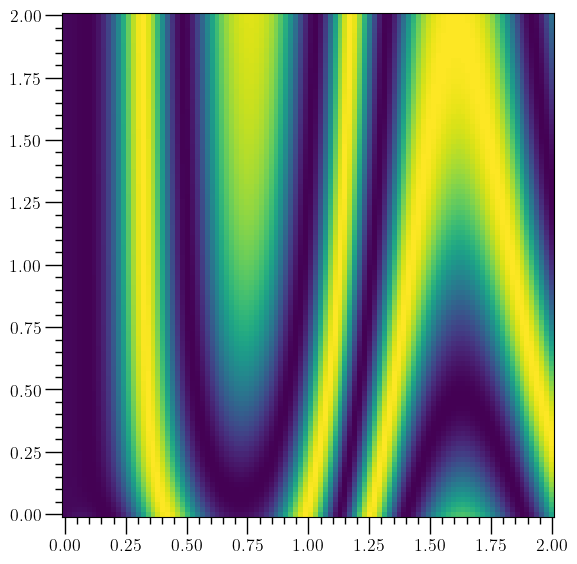

In [5]:
if plots:
    pl.canvas()
    pl.den_plot([t3d,"z"])
    pl.colbar=True
    #pl.xtitle('radius (km)')
    #pl.ytitle('gravitational mass (Msun)')
    plot.show()

Collect function values scattered across this plane:

In [6]:
import random
N=300
x2=numpy.zeros((N,2))
y2=numpy.zeros((N,1))
for i in range(0,N):
    x2[i,0]=random.random()*2.0
    x2[i,1]=random.random()*2.0
    y2[i,0]=t3d.interp(x2[i,0],x2[i,1],"z")

In [7]:
im=o2sclpy.interpm_sklearn_gp()
im.set_data_str(x2,y2,'test_size=0.1')

String: test_size=0.1 Dictionary: {'test_size': 0.1}
score: 0.9128715322580898


In [8]:
t3d.new_slice("gp")
for i in range(0,t3d.get_nx()):
    for j in range(0,t3d.get_ny()):
        x=t3d.get_grid_x(i)
        y=t3d.get_grid_y(j)
        t3d.set(i,j,"gp",im.eval(numpy.array([x,y])))

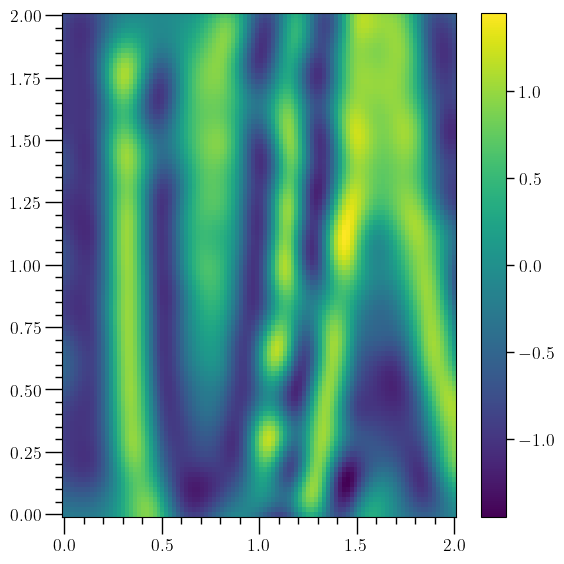

In [9]:
if plots:
    pl.canvas()
    pl.den_plot([t3d,"gp"])
    pl.colbar=True
    plot.show()

In [10]:
im2=o2sclpy.interpm_tf_dnn()
im2.set_data(x2,y2,verbose=1,epochs=200,
            test_size=0.0,batch_size=8,transform='none',
            activations=['relu','relu','relu','relu'],
            hlayers=[128,64,32,16])

2024-03-21 17:57:17.921347: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


interpm_tf_dnn::set_data():
  outformat: numpy
  in_data shape: (300, 2)
  out_data shape: (300, 1)
  batch_size: 8
  layers: [128, 64, 32, 16]
  activation functions: ['relu', 'relu', 'relu', 'relu']
  transform: none
  epochs: 200
  test_size: 0.0
min,max before transformation: -9.999737e-01 9.999758e-01
min,max after transformation : -9.999737e-01 9.999758e-01
nd_in,nd_out: 2 1
  Training DNN model.
Layer: dense 128 2 relu
Layer: dense 64 relu
Layer: dense 32 relu
Layer: dense 16 relu
Layer: dense 1 linear


/Users/awsteiner2/venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,265 (44.00 KB)

 Trainable params: 11,265 (44.00 KB)

 Non-trainable params: 0 (0.00 B)

summary: None
Epoch 1/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.5566   
Epoch 2/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step - loss: 0.5076
Epoch 3/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step - loss: 0.4747
Epoch 4/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step - loss: 0.4688
Epoch 5/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4734 
Epoch 6/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5103 
Epoch 7/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4544 
Epoch 8/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4277 
Epoch 9/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4670 
Epoch 10/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4397 
Epoch 11/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4627 
Epoch 12/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4410 
Epoch 13/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4460 
Epoch 14/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4520 
Epoch 15/200
38/38 ━━━━━━━━━━━━━━━━━━━

In [11]:
t3d.new_slice("nn")
for i in range(0,t3d.get_nx(),3):
    for j in range(0,t3d.get_ny(),3):
        x=t3d.get_grid_x(i)
        y=t3d.get_grid_y(j)
        print(x,y,im2.eval(numpy.array([x,y])))
        t3d.set(i,j,"nn",im2.eval(numpy.array([x,y])));
    print('i',i)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
0.0 0.0 [-0.97272295]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
0.0 0.06060606060606061 [-0.93558234]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
0.0 0.12121212121212122 [-0.89927703]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
0.0 0.18181818181818182 [-0.87571794]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
0.0 0.24242424242424243 [-0.86156356]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
0.0 0.30303030303030304 [-0.84819132]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
0.0 0.36363636363636365 [-0.83481914]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
0.0 0.42424242424242425 [-0.82547301]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
0.0 0.48484848484848486 [-0.81988901]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

/Users/awsteiner2/venv/lib/python3.12/site-packages/matplotlib/image.py:463: RuntimeWarning: overflow encountered in scalar multiply
  newmin = vmid - dv * fact
/Users/awsteiner2/venv/lib/python3.12/site-packages/matplotlib/image.py:468: RuntimeWarning: overflow encountered in scalar multiply
  newmax = vmid + dv * fact
/Users/awsteiner2/venv/lib/python3.12/site-packages/matplotlib/image.py:463: RuntimeWarning: overflow encountered in scalar multiply
  newmin = vmid - dv * fact
/Users/awsteiner2/venv/lib/python3.12/site-packages/matplotlib/image.py:468: RuntimeWarning: overflow encountered in scalar multiply
  newmax = vmid + dv * fact


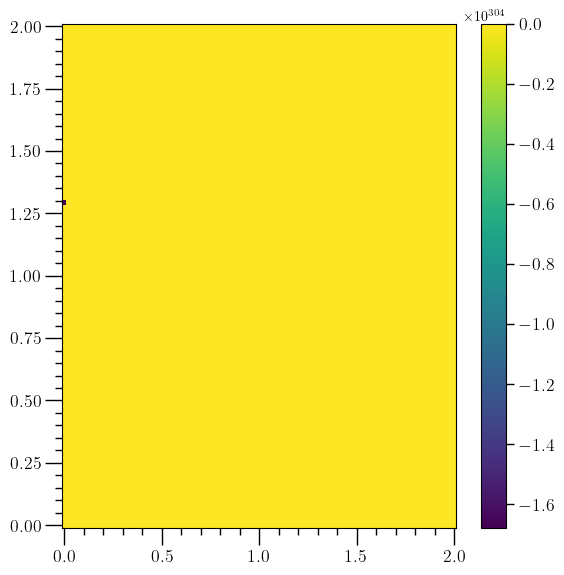

In [12]:
if plots:
    pl.canvas()
    pl.den_plot([t3d,"nn"])
    pl.colbar=True
    plot.show()